In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import itertools
import copy
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

import random

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from patsy import dmatrices

import iml_od_preprocessing
import iml_od_modelling

In [1387]:
data = pd.read_csv('CAR_Raw_Data.csv')

In [1388]:
desired_cols = ['Trial Id', 'Protocol #',  
                'Product Name', 'Full Title','Protocol Phase ',
                'Protocol Status','Therapeutic Area','Planned Enrollment',
                'Actual Enrollment','Actual Screened','Actual Rescreened','Actual Screen Failure',
                'Actual Randomized / Dosed','Actual Early Terminated','% Enrollment Completed',
                'Planned Sites','Active Sites','Legacy Company','CRO','Planned Primary Study Completion Date',
                'Actual Primary Study Completion Date','Synopsis Actual Date',
                'Protocol Actual Date',
                'First Site Activated Actual Date','FSS Actual Date',
                'FSI Actual Date','FSFV Actual Date','LSI Actual Date',
                'LSI Avg Tx Actual Date','LSO Actual Date',
                'LSO 2 Actual Date','LSO 3 Actual Date',
                'LSO 4 Actual Date','LSO Final Actual Date',
                'DBL Actual Date','DBL 2 Actual Date',
                'DBL 3  Actual Date','DBL 4 Actual Date',
                'DBL Final Actual Date']

In [1389]:
new_col_names = ['TrialID', 'ProtocolNum',  
                'ProductName', 'FullTitle','ProtocolPhase',
                'ProtocolStatus','TA','PlannedEnrollment',
                'ActualEnrollment','ActualScreened','ActualRescreened','ActualScreenFailure',
                'ActualRandomizedDosed','ActualEarlyTerminated','PercEnrollmentCompleted',
                'PlannedSites','ActiveSites','LegacyCompany','CRO','PlannedPrimaryStudy_CompletionDate',
                'ActualPrimaryStudy_CompletionDate','SynopsisActualDate','Protocol_ActualDate',
                'FirstSiteActivated_ActualDate','FSS_ActualDate',
                'FSI_ActualDate','FSFV_ActualDate','LSI_ActualDate',
                'LSI_AvgTx_ActualDate','LSO_ActualDate',
                'LSO_2_ActualDate','LSO_3_ActualDate',
                'LSO_4_ActualDate','LSO_Final_ActualDate',
                'DBL_ActualDate','DBL_2_ActualDate',
                'DBL_3_ActualDate','DBL_4_ActualDate',
                'DBL_Final_ActualDate']

In [1390]:
### Introducing a dictionary that maps interim phases to the generic ones 
def phase_map(x):
    phase_dict = {'I':['PHASE 1', 'I'], 'II':['IB', 'I/II', 'II', 'IIA', 'IIB'],
                  'III':['II/III', 'III', 'IIIA', 'IIIB']}
        
    if x in phase_dict['I']:
        return 'I'
    
    elif x in phase_dict['II']:
        return 'II'
    
    elif x in phase_dict['III']:
        return 'III'    
    
    else:
        return x

In [1394]:
df = data[desired_cols]
df.columns = new_col_names

-----

---------

In [1397]:
DBL_conds = df.DBL_ActualDate.notna() 
LSO_conds = df.LSO_ActualDate.notna()  
df = df[DBL_conds & LSO_conds]

df = df.replace(np.nan,0)
df = df.replace('*',0)


In [1398]:
# After Removing NAs
df.shape

(314, 39)

In [1400]:
def get_date_format(x):
    if x == 0:
        return '2500-01-01'
    elif x != 0: 
        new_val = datetime.strptime(str(x),'%m/%d/%Y').strftime('%Y-%m-%d')
        return new_val

In [1401]:
# Dealing with dates
date_cols = ['ActualPrimaryStudy_CompletionDate', 'SynopsisActualDate',
             'Protocol_ActualDate', 'FirstSiteActivated_ActualDate',
             'FSS_ActualDate', 'FSI_ActualDate', 'FSFV_ActualDate', 'LSI_ActualDate',
             'LSI_AvgTx_ActualDate', 'LSO_ActualDate', 'LSO_2_ActualDate', 
             'LSO_3_ActualDate', 'LSO_4_ActualDate', 'LSO_Final_ActualDate',
             'DBL_ActualDate','DBL_2_ActualDate', 'DBL_3_ActualDate',
             'DBL_4_ActualDate', 'DBL_Final_ActualDate']

for col in date_cols:
    df.loc[:, col] = df.loc[:, col].apply(lambda x: get_date_format(x))

In [1402]:
# Dealing with Phases 
df.loc[:, 'ProtocolPhase'] = df.ProtocolPhase.str.upper()
df.loc[:, 'ProtocolPhase'] = df.ProtocolPhase.apply(lambda x: phase_map(x))

# Dealing with TAs
NON_CORE_TAU = ['Plasma Derived Therapy', 'Ophthalmology', 'Immunology', 
                '0', 0, 'CVM', 'Vaccine', 'Others', 'Marketed Products']
df.loc[df.TA.isin(NON_CORE_TAU), ['TA']] = 'NonCore'

In [1403]:
# FY2021 = '01/01/2021'

In [1404]:
#temp_df = temp_df[(temp_df.DBL_ActualDate < FY2021) & (temp_df.LSO_ActualDate < FY2021)]

In [1405]:
#df = copy.deepcopy(temp_df)

### Finding the final LSO and DBL times to calculate cycle time

In [1406]:
def get_temp_df(df, cols):
    # Subsets df so that we focus only on LSO or DBL values
    
    if cols == 'LSO_cols':
        LSO_cols = ['LSO_ActualDate', 'LSO_2_ActualDate','LSO_3_ActualDate', 
                    'LSO_4_ActualDate', 'LSO_Final_ActualDate']
        mod_df = df[LSO_cols]

    if cols == 'DBL_cols':
        DBL_cols = ['DBL_ActualDate', 'DBL_2_ActualDate', 'DBL_3_ActualDate',
                    'DBL_4_ActualDate', 'DBL_Final_ActualDate']
        mod_df = df[DBL_cols]
        
    return mod_df

def get_true_date_val(series): 
    # Runs through each element in row to find what the last input date was
    i = 0
    for date in series:
        if date != '2500-01-01':
             val = date    
    return val

def get_true_date_col(df):
    # Yields the values for each row (different approach to lambda function)
    true_dates = list()
    for index, series in df.iterrows():
        true_dates.append(get_true_date_val(series))
    return true_dates

In [1407]:
LSO_df = get_temp_df(df, 'LSO_cols')
DBL_df = get_temp_df(df, 'DBL_cols')

In [1408]:
# ## Engineering the true LSO and DBL dates
# df['TrueLSO'] = pd.to_datetime(get_true_date_col(LSO_df))
# df['TrueDBL'] = pd.to_datetime(get_true_date_col(DBL_df))

df.DBL_ActualDate = pd.to_datetime(df.DBL_ActualDate)
df.LSO_ActualDate = pd.to_datetime(df.LSO_ActualDate)

In [1409]:
## Calculating the cycle time for the trial
df['CloseOut'] = (df.DBL_ActualDate - df.LSO_ActualDate) / pd.offsets.Day(1)
df['CloseOut'] = df['CloseOut'].astype(int)

### Engineering the number of times LSO and DBL was changed

In [1410]:
def get_count_changes(df):
    # Counts the number of dates are present in these rows - will equal number of times it has been changed
    
    df = df.replace('2500-01-01', np.nan)
    count_vals = list()
    for index, series in df.iterrows():
        count_vals.append(series.notna().sum())
    return count_vals

In [1411]:
df['numValsLSO'] = get_count_changes(LSO_df)
df['numValsDBL'] = get_count_changes(DBL_df)

### Engineering features for time between previous intermediate steps

In [1412]:
def get_time_diff(df, first_col, second_col):
    '''
    Calculates the number of days between two specified columns
    '''
    df.loc[:, first_col] = df.loc[:, first_col].replace('2500-01-01', np.nan) 
    df.loc[:, first_col] = pd.to_datetime(df.loc[:, first_col])
    
    df.loc[:, second_col] = df.loc[:, second_col].replace('2500-01-01', np.nan) 
    df.loc[:, second_col] = pd.to_datetime(df.loc[:, second_col])
    
    days_diff =  (df.loc[:, second_col] - df.loc[:, first_col]) / pd.offsets.Day(1)
    
    return days_diff
    

In [1413]:
interim_cols = {'PrimaryStudy_to_Synopsis': ('ActualPrimaryStudy_CompletionDate', 'SynopsisActualDate'),
                'Synopsis_to_Protocol': ('SynopsisActualDate','Protocol_ActualDate'),
                'Protocol_to_FirstSiteActivated': ('Protocol_ActualDate','FirstSiteActivated_ActualDate'),
                'FirstSiteActivated_to_FSS': ('FirstSiteActivated_ActualDate', 'FSS_ActualDate'),
                'FSS_to_FSI': ('FSS_ActualDate', 'FSI_ActualDate'),
                'FSI_to_FSFV': ('FSI_ActualDate', 'FSFV_ActualDate'),
                'FSFV_to_LSI': ('FSFV_ActualDate', 'LSI_ActualDate'),
                'LSI_to_LSIAvgTxL': ('LSI_ActualDate','LSI_AvgTx_ActualDate'), #IDK what LSI_AvgTx is
                'LSI_to_LSO': ('LSI_ActualDate', 'LSO_ActualDate')}

In [1414]:
# Will iterate through the columns pairs to create a new columns, corresponding to the time delta between the two
for cols in interim_cols:
    first_col = interim_cols[cols][0]
    second_col = interim_cols[cols][1]
    
    df[cols] = get_time_diff(df, first_col, second_col)

In [1415]:
df = df.loc[df.CloseOut > 25, :]

------

------

In [1416]:
#df.to_csv('processed_CAR_data.csv')

--------

/usr/local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='CloseOut', ylabel='Density'>

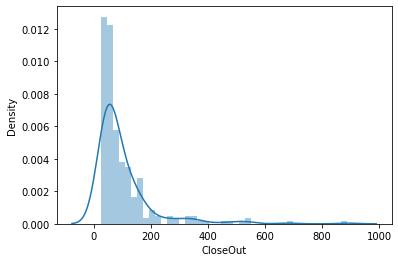

In [1417]:
sns.distplot(df.CloseOut)

In [1419]:
classes = ['<30 days', '30-52 days', '52-80 days', '>80 days']

-----

### Adding in number of missing domain data

In [1420]:
missing = pd.read_csv('study_missing_domain.csv')
missing = missing.drop(['Unnamed: 0'], axis = 1)
missing.columns = ['ProtocolNum', 'MissingDomain']

In [1421]:
sorted_ls = sorted(df.ProtocolNum.unique())

In [1422]:
'Vedolizumab-1014' == 'VEDOLIZUMAB-1014'

False

In [1423]:
temp = copy.deepcopy(df)
temp = temp.join(missing.set_index('ProtocolNum'), how = 'left', on = 'ProtocolNum').reset_index()
temp.MissingDomain = temp.MissingDomain.replace(np.nan, 0)

### ML on CAR Data

In [1424]:
wanted_cols = ['ProtocolPhase', 'TA', 'PlannedEnrollment', 'ActualEnrollment',
              'ActualScreened', 'ActualRescreened', 'ActualScreenFailure',
               'ActualRandomizedDosed', 'ActualEarlyTerminated',
               'PercEnrollmentCompleted', 'PlannedSites', 'ActiveSites',
               'CRO','numValsLSO','numValsDBL', 'DBL_ActualDate',
               'Synopsis_to_Protocol',
               'FSS_to_FSI','LSI_to_LSO', 'MissingDomain',
               'CloseOut']

In [1425]:
#ml_df = df[wanted_cols]
ml_df = temp[wanted_cols]

In [1426]:
## ML stuff

### Data Wrangling

In [1427]:
# Imputing data
ml_df.Synopsis_to_Protocol.fillna(ml_df.Synopsis_to_Protocol.median(), inplace= True)
ml_df.FSS_to_FSI.fillna(ml_df.FSS_to_FSI.median(), inplace= True)
ml_df.LSI_to_LSO.fillna(ml_df.LSI_to_LSO.median(), inplace= True)

/usr/local/lib64/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [1428]:
# Dealing with % values
def p2f(x):
    return float(x.strip('%'))/100

ml_df.loc[:, 'PercEnrollmentCompleted'] = ml_df.loc[:, 'PercEnrollmentCompleted'].astype(str)
ml_df.loc[:, 'PercEnrollmentCompleted'] = ml_df.loc[:, 'PercEnrollmentCompleted'].apply(lambda x: p2f(x))

/usr/local/lib64/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [1429]:
# Dealing with CROs 
ml_df.loc[:, 'CRO'] = ml_df.CRO.str.replace('Takeda PRA Development Center', 'PRA')
ml_df.loc[:, 'CRO'] = ml_df.CRO.str.replace('PRA Health Sciences', 'PRA')
ml_df.loc[:, 'CRO'] = ml_df.CRO.str.replace('ICON / MAPI / Paradigm', 'ICON')


NON_CORE_CRO = ['Hangzhou Tigermed Consulting', 'Atlant','TBD', 'TFS', 0, 
                'Hammersmith Medicines Research', 'GEICAM', 'INC Research',
                'CMIC', 'Parexel', 'Synteract','Sarah Cannon Research Institut', 
                'Dobbs Consulting', 'In-House','Covance', 'MEDISCIENCE PLANNING INC',
                'EPS', 'A2 Healthcare','Red Maple Trials, Rho, Triumpharma', 
                'Medpace', 'Endpoint', 'Clinical Pharmacology of Miami, INC',
                'Bracket', 'Psi', 'DMID-CROMS Pharmacovigilance Group', 'Chiltern',
                'Assign Group', 'Mediscience Planning Inc.', 'DP Clinical, Inc.']
ml_df.loc[ml_df.CRO.isin(NON_CORE_CRO), 'CRO'] = 'Other'

In [1430]:
## Final NAs
ml_df = ml_df.dropna(how = 'any')

## Dropping outliers 
ml_df = ml_df.loc[ml_df.CloseOut < 250, :]
ml_df = ml_df.loc[ml_df.CloseOut >= 0, :]

## Dealing with negative values on certain columns 
ml_df = ml_df.loc[ml_df.FSS_to_FSI >= 0, :]
ml_df = ml_df.loc[ml_df.Synopsis_to_Protocol >= 0, :]
ml_df = ml_df.loc[ml_df.LSI_to_LSO >= 0, :]

In [1431]:
## One Hot Encoding
## CRO
# Processing Columns
ml_df = iml_od_preprocessing.one_hot_encoding_one_column(ml_df, 'CRO')

## TA
ml_df = iml_od_preprocessing.one_hot_encoding_one_column(ml_df, 'TA')

## Phase
ml_df = iml_od_preprocessing.one_hot_encoding_one_column(ml_df, 'ProtocolPhase')

In [1432]:
# Fixing number values
ml_df.loc[:, 'PlannedEnrollment'] = ml_df.loc[:, 'PlannedEnrollment'].astype(str).apply(lambda x: x.replace(',',''))
ml_df.loc[:, 'PlannedEnrollment'] = ml_df.loc[:, 'PlannedEnrollment'].astype(int)

ml_df.loc[:, 'ActualEnrollment'] = ml_df.loc[:, 'ActualEnrollment'].astype(str).apply(lambda x: x.replace(',',''))
ml_df.loc[:, 'ActualEnrollment'] = ml_df.loc[:, 'ActualEnrollment'].astype(int)

### Dropping non-sensical columns

In [1433]:
# ActualRescreened dropped because it's all 0 values except for one that is 4
ml_df = ml_df.drop(['ActualRescreened'], axis=1)

# ActualScreened dropped because the values observed don't add up i.e. Enrolled != Screened - FailedScreen
ml_df = ml_df.drop(['ActualScreened'], axis=1)

### Visualizing correlations

In [1434]:
# Obtaining Correlations

corr_vals = list(ml_df.corr().CloseOut)

corr_names = list(ml_df.corr().index)

closeOut_idx = corr_names.index('CloseOut')

del corr_vals[closeOut_idx]
del corr_names[closeOut_idx]

In [1435]:
# Obtaining features with correlations greater than a threshold 
def features_above_corr(corr_names, corr_vals, threshold):
    
    new_vals = list()
    new_names = list()
    
    i = 0
    for val in corr_vals:
        if abs(val) > threshold:
            new_vals.append(corr_vals[i])
            new_names.append(corr_names[i])
        i+=1 
    
    print(f'There are {len(new_names)} features with a correlation greater than {100*round(threshold,2)}%')
    return new_names, new_vals

In [1436]:
def get_corr_bar_plot(corr_names, corr_vals, cutoff):
    
    threshold = cutoff
    most_corr_names, most_corr_vals = features_above_corr(corr_names, corr_vals, threshold)   
    
    plt.figure(figsize = (10,8))
    plt.title('Feature correlations with close-out times')
    plt.xlabel('Feature Name')
    plt.ylabel('Correlation')
    plt.xticks(rotation = 45)

    plt.bar(most_corr_names, most_corr_vals)
    
    pass 

In [1437]:
sum(df.DBL_ActualDate < '2010-01-01')

1

There are 14 features with a correlation greater than 5.0%


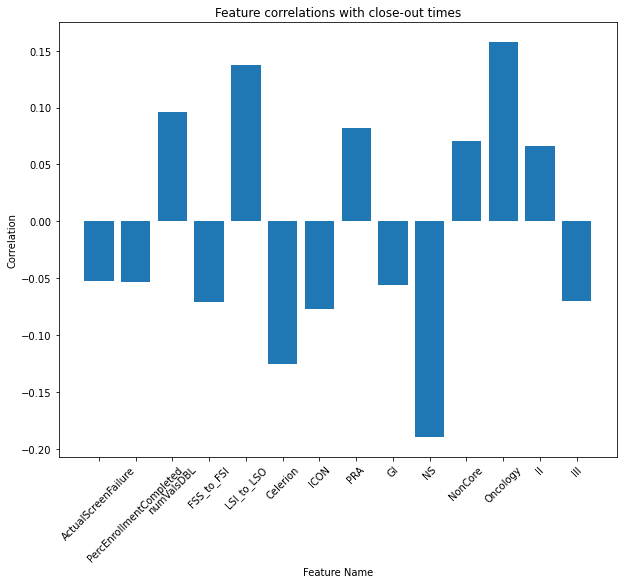

In [1438]:
cutoff = 0.05
get_corr_bar_plot(corr_names, corr_vals, cutoff)

In [1439]:
ml_df.columns

int_val_cols = ['PlannedEnrollment', 'ActualEnrollment',
                'ActualScreenFailure', 'ActualRandomizedDosed',
                'ActualEarlyTerminated', 'PercEnrollmentCompleted', 'PlannedSites',
                'ActiveSites', 'numValsLSO', 'numValsDBL',
                'Synopsis_to_Protocol', 'FSS_to_FSI', 'LSI_to_LSO']

In [1440]:
def get_data_viz(col, col_vals, CloseOut_vals):
    
    plt.figure(figsize = (8,6))
    plt.title(f'{col} vs. Close Out')
    plt.xlabel(col)
    plt.ylabel('Close Out (days)')
    
    return plt.scatter(col_vals, CloseOut_vals)

Generating 13 plots...


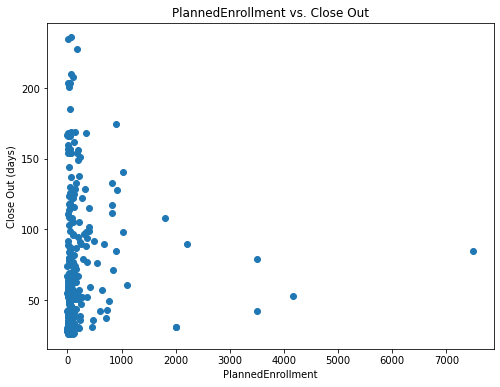

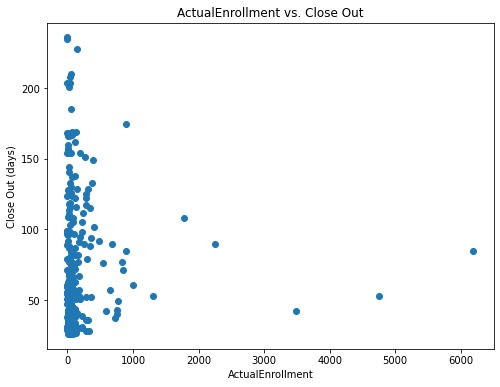

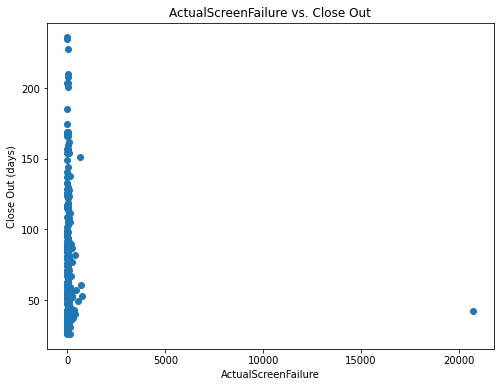

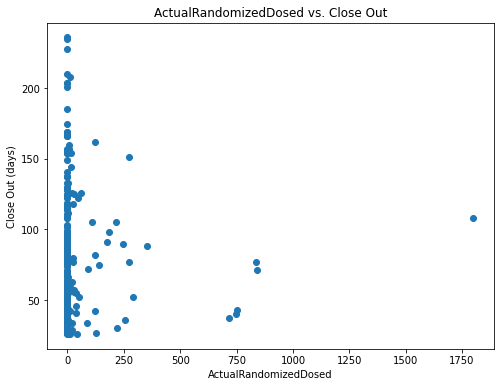

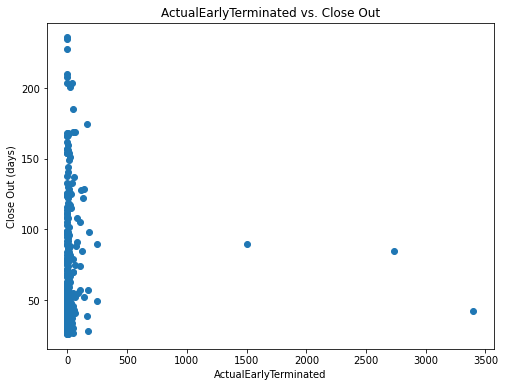

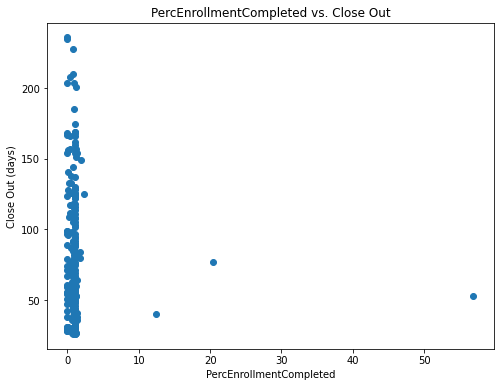

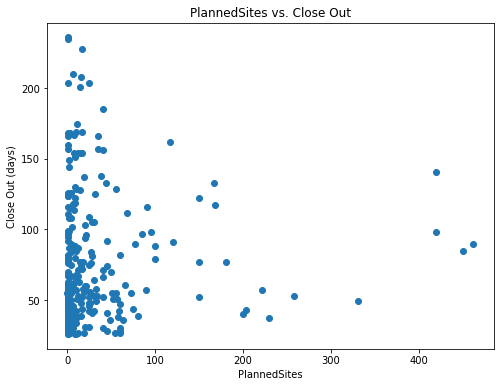

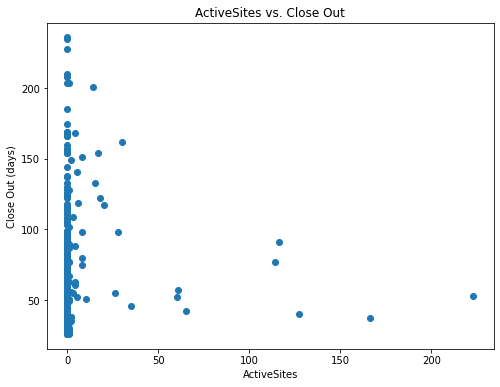

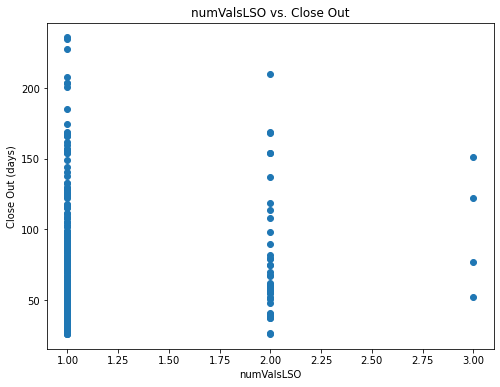

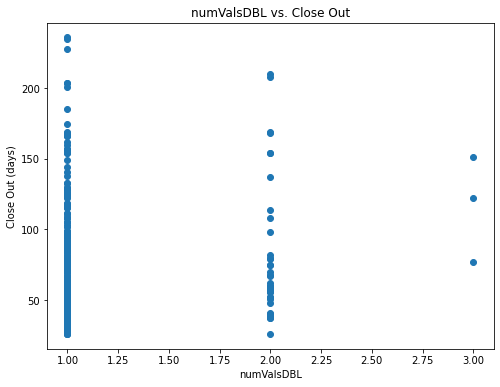

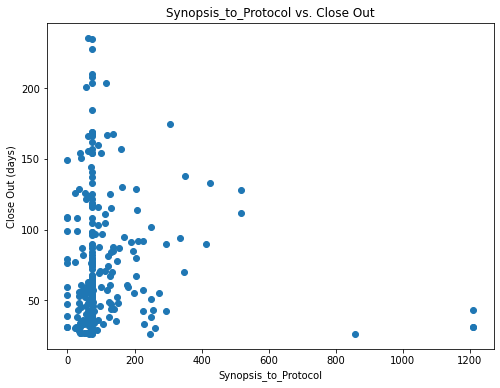

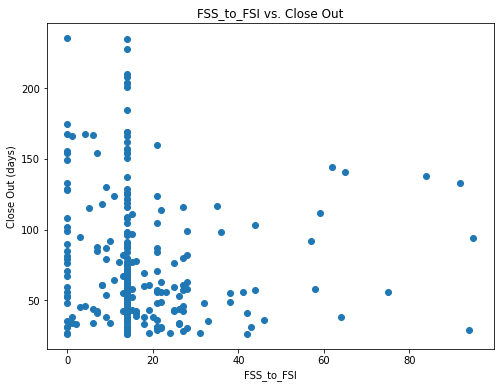

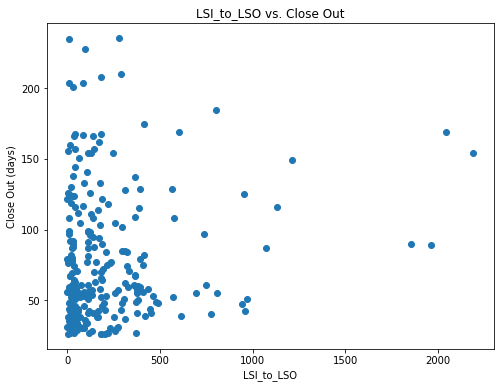

In [1441]:
sub_ml_df = ml_df[int_val_cols]
print(f'Generating {sub_ml_df.shape[1]} plots...')
for col in sub_ml_df:
    get_data_viz(col, sub_ml_df.loc[:, col], ml_df.CloseOut)

### Train-Test split 

In [1347]:
train = ml_df[ml_df.DBL_ActualDate < '2020-09-01']
train = train.drop(['DBL_ActualDate'], axis=1)

test = ml_df[ml_df.DBL_ActualDate >= '2020-09-01']
test = test.drop(['DBL_ActualDate'], axis=1)

In [1229]:
ml_df_weeks = copy.deepcopy(ml_df)

In [1230]:
# Converting CloseOut from days to weeks
def convert_to_weeks(x):
    '''
    Converting days (days considered as working days) to working weeks
    '''
    
    days = x
    days_in_week = 5
    
    weeks = int(round(days/days_in_week, 0))
    return weeks

ml_df_weeks.loc[:, 'CloseOut'] = ml_df_weeks.loc[:, 'CloseOut'].apply(lambda x: convert_to_weeks(x)) 

(163, 31)

In [1205]:
# Predicting on the number of weeks
train = ml_df_weeks[ml_df_weeks.DBL_ActualDate < '2020-09-01']
train = train.drop(['DBL_ActualDate'], axis=1)

test = ml_df_weeks[ml_df_weeks.DBL_ActualDate >= '2020-09-01']
test = test.drop(['DBL_ActualDate'], axis=1)

In [1237]:
# Predicting on the number of weeks before COVID
train = ml_df_weeks[ml_df_weeks.DBL_ActualDate < '2019-03-14']
train = train.drop(['DBL_ActualDate'], axis=1)

test = ml_df_weeks[(ml_df_weeks.DBL_ActualDate >= '2019-03-14') & (ml_df_weeks.DBL_ActualDate < '2020-03-15')]
test = test.drop(['DBL_ActualDate'], axis=1)

(array([15., 81., 76., 34., 24., 19., 12.,  9.,  5.,  3.]),
 array([ 0. ,  4.7,  9.4, 14.1, 18.8, 23.5, 28.2, 32.9, 37.6, 42.3, 47. ]),
 <BarContainer object of 10 artists>)

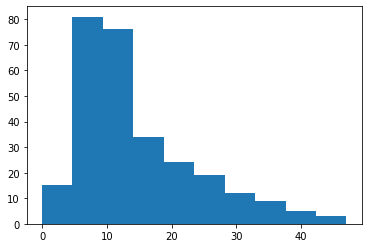

In [1232]:
plt.hist(ml_df_weeks.CloseOut)

In [1236]:
ml_df_weeks.CloseOut.max(), ml_df_weeks.CloseOut.min(), ml_df_weeks.CloseOut.median()

(47, 0, 11.5)

In [1249]:
def get_class_labels(x):
    
    if x <= 6:
        x = '<6 weeks'
    elif (x > 6) & (x <= 9):
        x = '7-9 weeks'
    elif (x > 9) & (x <= 14):
        x = '10-14 weeks'
    elif x >= 15:
        x = '>=15 weeks'
    return x
    

In [1250]:
ml_df_weeks['Classes'] = ml_df_weeks.loc[:, 'CloseOut'].apply(lambda x: get_class_labels(x))

In [1251]:
ml_df_weeks.Classes.value_counts()

>=15 weeks     106
10-14 weeks     76
7-9 weeks       50
<6 weeks        46
Name: Classes, dtype: int64

In [1348]:
def get_train_test_data(train, test):
    '''
    Grouping together the training/testing specifications
    '''
    
    # Train data 
    y_train = train.loc[:, 'CloseOut']
    x_train = train.loc[:, train.columns != 'CloseOut']


    #x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)

    # Test data
    y_test = test.loc[:, 'CloseOut']
    x_test = test.loc[:, test.columns != 'CloseOut']


    x_trainvalid = x_train
    y_trainvalid = y_train

    ordinal_features = x_train.columns
    ordinal_transformer = Pipeline(steps = [
        ('imputer', SimpleImputer(strategy='median')),
         ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
            [('ord', ordinal_transformer, ordinal_features)]
    )

    x_train_processed = preprocessor.fit_transform(x_train)
    x_test_processed = preprocessor.transform(x_test)

    x_trainvalid_processed = x_train_processed  
    return x_train_processed, x_test_processed, x_trainvalid_processed, y_train, y_test, y_trainvalid


x_train_processed, x_test_processed, x_trainvalid_processed, y_train, y_test, y_trainvalid = get_train_test_data(train, test)

In [1349]:
## Modelling 
def run_ml(select_seed):
    random.seed(select_seed)
    n_trials = 100

    lm_results = iml_od_modelling.linear_model(x_trainvalid = x_trainvalid_processed, 
                              x_test = x_test_processed, 
                              y_trainvalid = y_trainvalid, 
                              y_test = y_test)

    df_linear_model = pd.DataFrame(lm_results, index=[0])

    lasso_results = iml_od_modelling.linear_lasso(x_tr = x_train_processed, 
    #                                              x_val = x_valid_processed, 
                                                 x_te = x_test_processed, 
                                                 x_trval = x_trainvalid_processed, 
                                                 y_tr = y_train, 
    #                                              y_val = y_valid, 
                                                 y_te = y_test, 
                                                 y_trval= y_trainvalid, 
                                                 n_trials = n_trials)

    df_lasso = pd.DataFrame(lasso_results, index = [1])

    ridge_results = iml_od_modelling.linear_ridge(x_tr = x_train_processed, 
    #                                              x_val = x_valid_processed, 
                                                 x_te = x_test_processed, 
                                                 x_trval = x_trainvalid_processed, 
                                                 y_tr = y_train, 
    #                                              y_val = y_valid, 
                                                 y_te = y_test, 
                                                 y_trval = y_trainvalid, 
                                                 n_trials = n_trials)

    df_ridge = pd.DataFrame(ridge_results, index = [2])

    decision_tree_results = iml_od_modelling.decision_tree(x_tr = x_train_processed, 
    #                                                      x_val = x_valid_processed, 
                                                         x_te = x_test_processed, 
                                                         x_trval = x_trainvalid_processed, 
                                                         y_tr = y_train, 
    #                                                      y_val = y_valid, 
                                                         y_te = y_test, 
                                                         y_trval = y_trainvalid, 
                                                         n_trials = n_trials)

    df_decision_tree = pd.DataFrame(decision_tree_results, index = [3])

#     lightgbm_results = iml_od_modelling.lightgbm_model(x_tr = x_train_processed, 
#     #                                                      x_val = x_valid_processed, 
#                                                          x_te = x_test_processed, 
#                                                          x_trval = x_trainvalid_processed, 
#                                                          y_tr = y_train, 
#     #                                                      y_val = y_valid, 
#                                                          y_te = y_test, 
#                                                          y_trval = y_trainvalid, 
#                                                          n_trials = n_trials)

#     df_lightgbm = pd.DataFrame(lightgbm_results, index = [4])

    # poisson_regression_results = iml_od_modelling.poisson_regression(x_tr = x_train_processed, 
    # #                                                      x_val = x_valid_processed, 
    #                                                      x_te = x_test_processed, 
    #                                                      x_trval = x_trainvalid_processed, 
    #                                                      y_tr = y_train, 
    # #                                                      y_val = y_valid, 
    #                                                      y_te = y_test, 
    #                                                      y_trval = y_trainvalid, 
    #                                                      n_trials = n_trials)

    # df_poisson_regression = pd.DataFrame(poisson_regression_results, index = [4])

    rf_results = iml_od_modelling.rf_model(x_tr = x_train_processed, 
    #                                                      x_val = x_valid_processed, 
                                                         x_te = x_test_processed, 
                                                         x_trval = x_trainvalid_processed, 
                                                         y_tr = y_train, 
    #                                                      y_val = y_valid, 
                                                         y_te = y_test, 
                                                         y_trval = y_trainvalid, 
                                                         n_trials = n_trials)

    df_random_forest = pd.DataFrame(rf_results, index = [4])
    
    xgb_results = iml_od_modelling.xgb_model(x_tr = x_train_processed, 
    #                                                      x_val = x_valid_processed, 
                                                         x_te = x_test_processed, 
                                                         x_trval = x_trainvalid_processed, 
                                                         y_tr = y_train, 
    #                                                      y_val = y_valid, 
                                                         y_te = y_test, 
                                                         y_trval = y_trainvalid, 
                                                         n_trials = n_trials)

    df_xgb = pd.DataFrame(xgb_results, index = [5])


    results_concat = pd.concat([df_linear_model, 
                                df_lasso, 
                                df_ridge, 
                                df_decision_tree, 
    #                             df_poisson_regression,
#                                df_lightgbm,
                                df_random_forest,
                                df_xgb
                               ])

#    print(results_concat)

    return results_concat

In [1350]:
select_seed = 2
results_concat = run_ml(select_seed)

[I 2021-08-04 21:10:06,539] A new study created in memory with name: no-name-203b08fa-695f-4b54-855b-a24f2eb99d4b


Time for preparing linear model result:  0.0  minutes


[I 2021-08-04 21:10:06,879] Trial 0 finished with value: -2234.5578940211794 and parameters: {'lasso_alpha': 4.1702200528555196}. Best is trial 0 with value: -2234.5578940211794.
[I 2021-08-04 21:10:06,888] Trial 1 finished with value: -2230.3644990734515 and parameters: {'lasso_alpha': 7.203244937218336}. Best is trial 1 with value: -2230.3644990734515.
/mnt/efs/home/glc8688/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13283.25443328722, tolerance: 33.76918987341772
  positive)
/mnt/efs/home/glc8688/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6725.435873425449, tolerance: 35.65434430379747
  positive)
/mnt/efs/home/glc8688/.local/lib/python3.6/site-packages/sklearn/linear_model/_coor

Time for preparing Lasso result:  0.02  minutes


[I 2021-08-04 21:10:08,088] Trial 20 finished with value: -2841.912782009858 and parameters: {'ridge_alpha': 8.007445688747922}. Best is trial 13 with value: -2826.409601772079.
[I 2021-08-04 21:10:08,097] Trial 21 finished with value: -2809.752356439572 and parameters: {'ridge_alpha': 9.682615757511359}. Best is trial 21 with value: -2809.752356439572.
[I 2021-08-04 21:10:08,106] Trial 22 finished with value: -2997.862316219369 and parameters: {'ridge_alpha': 3.134241788458186}. Best is trial 21 with value: -2809.752356439572.
[I 2021-08-04 21:10:08,115] Trial 23 finished with value: -2866.027564506519 and parameters: {'ridge_alpha': 6.923226159769914}. Best is trial 21 with value: -2809.752356439572.
[I 2021-08-04 21:10:08,123] Trial 24 finished with value: -2826.742823542719 and parameters: {'ridge_alpha': 8.763891524196492}. Best is trial 21 with value: -2809.752356439572.
[I 2021-08-04 21:10:08,132] Trial 25 finished with value: -2823.258146624446 and parameters: {'ridge_alpha': 8

Time for preparing Ridge result:  0.02  minutes


[I 2021-08-04 21:10:09,305] Trial 0 finished with value: -0.275015307042531 and parameters: {'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 2, 'ccp_alpha': 3.0233257332950716}. Best is trial 0 with value: -0.275015307042531.
[I 2021-08-04 21:10:09,316] Trial 1 finished with value: -0.13924838362737982 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'ccp_alpha': 3.45560727697487}. Best is trial 1 with value: -0.13924838362737982.
[I 2021-08-04 21:10:09,328] Trial 2 finished with value: -0.21700758094142572 and parameters: {'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 9, 'ccp_alpha': 6.852195007115399}. Best is trial 1 with value: -0.13924838362737982.
[I 2021-08-04 21:10:09,339] Trial 3 finished with value: -0.13952102288756127 and parameters: {'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 2, 'ccp_alpha': 6.704675105079347}. Best is trial 1 with value: -0.13924838362737982.
[I 2021-08-04 21:10:09,351] Trial 4 f

Time for preparing Ridge result:  0.03  minutes


[I 2021-08-04 21:10:10,892] Trial 0 finished with value: -0.13261421729669545 and parameters: {'max_depth': 9, 'n_estimators': 38}. Best is trial 0 with value: -0.13261421729669545.
[I 2021-08-04 21:10:11,023] Trial 1 finished with value: -0.05547444817792424 and parameters: {'max_depth': 2, 'n_estimators': 18}. Best is trial 1 with value: -0.05547444817792424.
[I 2021-08-04 21:10:11,101] Trial 2 finished with value: -0.1100019593638415 and parameters: {'max_depth': 4, 'n_estimators': 9}. Best is trial 1 with value: -0.05547444817792424.
[I 2021-08-04 21:10:11,268] Trial 3 finished with value: -0.15154680424139907 and parameters: {'max_depth': 5, 'n_estimators': 20}. Best is trial 1 with value: -0.05547444817792424.
[I 2021-08-04 21:10:11,539] Trial 4 finished with value: -0.09658639309001926 and parameters: {'max_depth': 9, 'n_estimators': 29}. Best is trial 1 with value: -0.05547444817792424.
[I 2021-08-04 21:10:11,870] Trial 5 finished with value: -0.11024350408304762 and parameters

Time for preparing Random Forest result:  0.55  minutes


[I 2021-08-04 21:10:46,187] Trial 0 finished with value: -2.4302235877178754e+27 and parameters: {'lambda': 0.04656804637919568, 'alpha': 0.7608481233714796, 'subsample': 1, 'learning_rate': 3.9676807746319573, 'n_estimators': 29, 'max_depth': 9}. Best is trial 0 with value: -2.4302235877178754e+27.
[I 2021-08-04 21:11:44,873] Trial 1 finished with value: -6708015569.052054 and parameters: {'lambda': 0.5506529897945993, 'alpha': 0.0065736866551383355, 'subsample': 0.4, 'learning_rate': 1.9810229098338972, 'n_estimators': 41, 'max_depth': 20}. Best is trial 1 with value: -6708015569.052054.
[I 2021-08-04 21:12:35,001] Trial 2 finished with value: -6.52275664507162 and parameters: {'lambda': 0.017934807211789795, 'alpha': 0.5878824056644089, 'subsample': 0.5, 'learning_rate': 0.9834773548621626, 'n_estimators': 24, 'max_depth': 20}. Best is trial 2 with value: -6.52275664507162.
[I 2021-08-04 21:13:00,937] Trial 3 finished with value: -2.156555962792488e+27 and parameters: {'lambda': 0.1

Time for preparing XGB result:  40.93  minutes


In [1351]:
results_concat

,model_name,hyperparameters,mse_train,mse_test,mae_train,mae_test,metric_validation,r2_train,r2_test
0,linear_model,NaN,1820.536766,2905.506578,33.226168,40.613932,NaN,0.183052,-0.544173
1,lasso_linear_model,{'lasso_alpha': 9.682615757511359},2208.803214,2041.583118,36.257234,36.913881,-2226.549075,0.008822,-0.085028
2,ridge_linear_model,{'ridge_alpha': 9.888610889176336},1827.630705,2745.727483,33.247246,39.537152,-2806.128808,0.179869,-0.459256
3,decision_tree_model,"{'max_depth': 17, 'min_samples_split': 20, 'mi...",1363.281900,2990.134258,27.205236,43.561691,-0.048636,0.388241,-0.589149
4,rf_model,"{'max_depth': 2, 'n_estimators': 47}",1837.672997,2067.005678,33.164222,36.017890,-0.039630,0.175363,-0.098539
5,xgb_model,"{'lambda': 0.01449412452654265, 'alpha': 0.007...",410.430984,3347.329568,14.343807,45.952609,-0.219875,0.815823,-0.778986


In [1209]:
# Results on Normalized data (testing on 2021) --> Predicting number of weeks (nominal)
results_concat

,model_name,hyperparameters,mse_train,mse_test,mae_train,mae_test,metric_validation,r2_train,r2_test
0,linear_model,NaN,2.874191,5.208494,1.321597,1.775524,NaN,0.184181,-0.538982
1,lasso_linear_model,{'lasso_alpha': 0.39054784193827574},3.499900,3.697686,1.446466,1.604901,-3.520009,0.006578,-0.092576
2,ridge_linear_model,{'ridge_alpha': 9.888610889176336},2.885498,4.876187,1.323797,1.735755,-4.481061,0.180971,-0.440794
3,decision_tree_model,"{'max_depth': 9, 'min_samples_split': 15, 'min...",3.523074,3.702556,1.451416,1.603361,-0.002665,0.000000,-0.094015
4,rf_model,"{'max_depth': 2, 'n_estimators': 36}",2.893269,3.717874,1.307547,1.582674,-0.032851,0.178766,-0.098541
5,xgb_model,"{'lambda': 0.01449412452654265, 'alpha': 0.007...",0.527831,5.019451,0.516060,1.835030,-0.213565,0.850179,-0.483125


In [ ]:
# Results on Log-data

-----

## Back Up

In [805]:
SQL_trial_ids = ['10201806038', '10201806040', '10201806042', '10201807001','1-10ELOL', '10201806015', 
                 '10201806026', '10201806025','10201806027', '1-106BXY', '1-10ELPN', '10201806030',
                 '10201806033', '1-10ELZC', '1-12MXSR', '1-12LDAB', '1-1EIAU4','1-1EIAUN', 
                 '1-1EIAVJ', '1-1EIATT', '1-1L0NQP', '1-26JYIY',
                 '1-2IFHJV', '1-1S6QUZ', '1-274PTK', '1-1ZTG51', '1-21HO75',
                 '1-2GG2AA', '0624-209', '1-39REHV', '1-2YLIZL', '1-3ELU49',
                 '1-2IFHK7', '1-9I7GV', '1-CK4HM', '1-8R8L', '1-8UMZ', '1-DT93H',
                 '1-ZA6XT', '1-EEZ99', '1-ZD7XX', '1-F28N', '1-ZD80O', '1-ZD8AP',
                 '1-F2HY', '1-8UPO', '1-F9CI7', 'SHP615-301', '1-P37UL', '1-QCXSG',
                 '1-ZA6U1', 'SHP633-306', '1-EGKBL', 'SHP634-102', '1-ZA6UB',
                 'SHP640-301', 'SHP643-101', '1-ZA71B', '1-HTT6P', '1-ZD0NM',
                 'SPD489-348', '1-ZD0UY', 'VV_DEN_204', '1-ZD7XO', '1-ZF5YO',
                 '1-INX3G', '1-MGEGX', '471101', 'SHP621-302', 'SHP633-303',
                 '1-ZA6X2', '1-ZA70B', 'SHP633-304', 'SHPELA-701', '1-ZA722',
                 '1-ZA72K', 'SHP633-301', 'SHP639-101', 'TED-C13-003', '1-10XM9M',
                 '1-17VBPS', '1-1BP8VZ', '10201806041', '10201901001', '1-1KXHY2',
                 '1-1VZYNQ ', '1-1VZYOT', '1-23H347', '1-24RE13', '1-24RELR',
                 '1-2J1GSP', '1-32PVS7', '1-3DYCDM', '1-CJRPD', '1-F6HHL',
                 '1-G14DR', '1-V5BIE', '1-ZA6W2', '1-ZA6WK', '1-ZA71K', '1-ZD88J',
                 '1-ZD8CA', '1-ZF5WP', '1-ZF5X1', '1-ZF60M', 'DX-2930-03',
                 'HGT-HIT-094', 'SHP615-302', 'SHP616-300', 'SHP633-302',
                 'SHP634-404', 'SHP647-305', 'TED-C14-006', 'VV_DEN_203-2',
                 '071301', '091301', '10201806029', '1-1026F0', '1-10FGX3',
                 '1-10FLG7', '10201806006', '10201806022', '1-1146BQ', '1-13KZMH',
                 '1-1GDNNZ', '1-1HVXQ3', '1-1MZ2O7', '1-1X3FRR', '1-24REN3',
                 '1-26UPF5', '1-274Q4X', '1-3BD3YR', '1-3SDL33', '1-8VE8X',
                 '1-9GYS5', '1-HTWUL', '1-U0EGW', '1-ZA6ZB', '1-ZD806', '1-ZD80F',
                 '1-ZD857', '1-ZF5XK', '1-ZF5ZJ', 'HGT-MLD-070', 'ROPP-2008-01',
                 'SHP465-308', 'SHP465-309', 'SHP621-301', 'SHP-GCB-402',
                 '10201806007', '10201806013', '1-1CJZCS', '1-1FQOMT', '1-1FQOV2',
                 '1-25CUUR', '1-30EE6J', '1-34WP2Q', '1-3D8NXB', '1-8UNO',
                 '1-ACL3H', '1-GG0OZ', '1-JLM1X', '1-LSEIL', '1-ZA6UK', '1-ZA6WT',
                 '1-ZD0OZ', '1-ZD0ST', '1-ZD7ZJ', '1-ZD7ZX', '1-ZD88A', '1-ZD8BA',
                 '241302', 'DX-2930-04', '1-1DC1ZJ', '1-1VZYMN ', '1-2H721R',
                 '1-3A58P8', '1-ZA6XK', '1-ZF5Z0', 'PAR-C10-008', 'SHP465-112',
                 'SHP634-101', 'SHP634-104', 'SHP640-302', 'SHP640-303',
                 'SHP647-301', 'SHP647-306', '1-17X9H9', '1-1CJZCH', '1-1VZYOK',
                 '1-8UOZ', '1-F29M', '1-F2HL', '1-HC2H3', '1-L6PF9', '1-L7IAF',
                 '1-ZA6YK', '1-ZD0Q2', '1-ZD0UF', '1-ZD87D', '1-ZD87X', '1-ZOEF2',
                 'SHP616-301', 'SHP620-303', 'SHP634-103', 'SHP643-102',
                 'SHP647-302', 'TAK-743-1003', 'VV_NOR_211']

SQL_trial_ids = set(SQL_trial_ids)

In [819]:
# Comparing the IDs we have against the IDs Scion has 

## Note: We have IDs only for trials that were completed or closed. Scion includes multiple categories
CAR_trial_ids = set(list(df.TrialID))

our_ids = len(SQL_trial_ids)
CAR_ids = len(CAR_trial_ids)
intersection = list(SQL_trial_ids & CAR_trial_ids) # So we know how many IDs we share

print(f'We have {our_ids} trial IDs')
print(f'CAR has {CAR_ids} trial IDs')
print(f'We share {len(intersection)} IDs')

We have 209 trial IDs
CAR has 314 trial IDs
We share 181 IDs


In [892]:
new_ids = CAR_trial_ids - SQL_trial_ids

In [824]:
SQL_data = pd.read_csv('processed_data.csv')

In [864]:
sub_df = df[['TrialID', 'ProtocolStatus', 'PlannedEnrollment', 
             'LSO_ActualDate', 'DBL_ActualDate', 'TA', 'CRO', 
             'ProtocolPhase']]

date_cols = ['LSO_ActualDate', 'DBL_ActualDate']

for col in date_cols:
    sub_df.loc[:, col] = sub_df.loc[:, col].apply(lambda x: get_date_format(x))
    
sub_df.loc[:, 'ProtocolPhase'] = sub_df.ProtocolPhase.str.upper()
sub_df.loc[:, 'ProtocolPhase'] = sub_df.ProtocolPhase.apply(lambda x: phase_map(x))

sub_df.loc[:, 'DBL_ActualDate'] = pd.to_datetime(sub_df.loc[:, 'DBL_ActualDate'])
sub_df.loc[:, 'LSO_ActualDate'] = pd.to_datetime(sub_df.loc[:, 'LSO_ActualDate'])

sub_df['CloseOut'] = sub_df['CloseOut'] = (sub_df.DBL_ActualDate - sub_df.LSO_ActualDate) / pd.offsets.Day(1)
sub_df['CloseOut'] = sub_df['CloseOut'].astype(int)



# Dealing with CROs 
sub_df.loc[:, 'CRO'] = sub_df.CRO.str.replace('Takeda PRA Development Center', 'PRA')
sub_df.loc[:, 'CRO'] = sub_df.CRO.str.replace('PRA Health Sciences', 'PRA')
sub_df.loc[:, 'CRO'] = sub_df.CRO.str.replace('ICON / MAPI / Paradigm', 'ICON')


NON_CORE_CRO = ['Hangzhou Tigermed Consulting', 'Atlant','TBD', 'TFS', 0, 
                'Hammersmith Medicines Research', 'GEICAM', 'INC Research',
                'CMIC', 'Parexel', 'Synteract','Sarah Cannon Research Institut', 
                'Dobbs Consulting', 'In-House','Covance', 'MEDISCIENCE PLANNING INC',
                'EPS', 'A2 Healthcare','Red Maple Trials, Rho, Triumpharma', 
                'Medpace', 'Endpoint', 'Clinical Pharmacology of Miami, INC',
                'Bracket', 'Psi', 'DMID-CROMS Pharmacovigilance Group', 'Chiltern',
                'Assign Group', 'Mediscience Planning Inc.', 'DP Clinical, Inc.']
sub_df.loc[sub_df.CRO.isin(NON_CORE_CRO), 'CRO'] = 'Other'

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [866]:
sub_df.columns

Index(['TrialID', 'ProtocolStatus', 'PlannedEnrollment', 'LSO_ActualDate',
       'DBL_ActualDate', 'TA', 'CRO', 'ProtocolPhase', 'CloseOut'],
      dtype='object')

In [875]:
sub_CAR_data = sub_df[['TrialID', 'ProtocolStatus', 'PlannedEnrollment', 
                       'TA','ProtocolPhase', 'CRO', 'CloseOut']]

In [887]:
sub_SQL_data = SQL_data[['Trial_id', 'Status', 'Planned_enrollment', 
                         'GeneralTA', 'Phase', 'CRO', 'Close_out']]


# Dealing with CROs 
sub_SQL_data.loc[:, 'CRO'] = sub_SQL_data.CRO.str.replace('Takeda PRA Development Center', 'PRA')
sub_SQL_data.loc[:, 'CRO'] = sub_SQL_data.CRO.str.replace('PRA Health Sciences', 'PRA')
sub_SQL_data.loc[:, 'CRO'] = sub_SQL_data.CRO.str.replace('ICON / MAPI / Paradigm', 'ICON')


NON_CORE_CRO = ['Hangzhou Tigermed Consulting', 'Atlant','TBD', 'TFS', 0, 
                'Hammersmith Medicines Research', 'GEICAM', 'INC Research',
                'CMIC', 'Parexel', 'Synteract','Sarah Cannon Research Institut', 
                'Dobbs Consulting', 'In-House','Covance', 'MEDISCIENCE PLANNING INC',
                'EPS', 'A2 Healthcare','Red Maple Trials, Rho, Triumpharma', 
                'Medpace', 'Endpoint', 'Clinical Pharmacology of Miami, INC',
                'Bracket', 'Psi', 'DMID-CROMS Pharmacovigilance Group', 'Chiltern',
                'Assign Group', 'Mediscience Planning Inc.', 'DP Clinical, Inc.', 'MEDISCIENCE']
sub_SQL_data.loc[sub_SQL_data.CRO.isin(NON_CORE_CRO), 'CRO'] = 'Other'

sub_SQL_data.columns = ['TrialID', 'ProtocolStatus', 'PlannedEnrollment', 
                        'TA', 'ProtocolPhase','CRO', 'CloseOut']

In [888]:
sub_CAR_data

,TrialID,ProtocolStatus,PlannedEnrollment,TA,ProtocolPhase,CRO,CloseOut
0,1-1ASDLD,Terminated,46,NS,I,PPD,289
7,1-1BKVJT,Recruitment Complete,40,Oncology,III,PPD,51
9,1-1BKVML,Recruitment Complete,22,Oncology,I,IQVIA,59
11,1-1BP8VZ,Closed,30,GI,I,IQVIA,6
14,1-1CJZC7,Terminated,830,GI,III,IQVIA,112
...,...,...,...,...,...,...,...
3045,VV_NOR_202,Completed,840,Vaccine,II,IQVIA,71
3046,VV_NOR_204,Completed,325,Vaccine,II,PPD,129
3050,VV_NOR_210,Completed,50,Vaccine,II,PPD,48
3051,VV_NOR_211,Completed,"4,176",Vaccine,II,IQVIA,53


In [889]:
sub_SQL_data

,TrialID,ProtocolStatus,PlannedEnrollment,TA,ProtocolPhase,CRO,CloseOut
0,10201806004,Enrollment Complete,32,Oncology,II,PRA,56
1,10201806038,Closed,96,GI,I,PRA,103
2,10201806040,Closed,278,GI,III,Other,170
3,10201806043,"Active, Not Recruiting",16,Oncology,II,Other,89
4,10201902001,Enrolling,14,Oncology,I,PPD,0
...,...,...,...,...,...,...,...
310,SHP634-103,Completed,58,RGH,I,Other,126
311,SHP643-102,Completed,190,RGH,I,PPD,52
312,SHP647-302,Completed,825,GI,III,Other,117
313,TAK-743-1003,Completed,12,NonCore,I,Celerion,47


In [897]:
ext_CAR_data = sub_CAR_data.loc[sub_CAR_data.TrialID.isin(new_ids), :]

In [898]:
new_df = copy.deepcopy(sub_SQL_data)

In [901]:
new_df = new_df.append(ext_CAR_data)

In [902]:
new_df

,TrialID,ProtocolStatus,PlannedEnrollment,TA,ProtocolPhase,CRO,CloseOut
0,10201806004,Enrollment Complete,32,Oncology,II,PRA,56
1,10201806038,Closed,96,GI,I,PRA,103
2,10201806040,Closed,278,GI,III,Other,170
3,10201806043,"Active, Not Recruiting",16,Oncology,II,Other,89
4,10201902001,Enrolling,14,Oncology,I,PPD,0
...,...,...,...,...,...,...,...
3044,VV_NOR_201,Reported,450,Vaccine,II,IQVIA,18
3045,VV_NOR_202,Completed,840,Vaccine,II,IQVIA,71
3046,VV_NOR_204,Completed,325,Vaccine,II,PPD,129
3050,VV_NOR_210,Completed,50,Vaccine,II,PPD,48


In [913]:
same_CAR_data = sub_CAR_data.loc[sub_CAR_data.TrialID.isin(intersection), :]
same_SQL_data = sub_SQL_data.loc[sub_SQL_data.TrialID.isin(intersection), :]

/usr/local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='CloseOut', ylabel='Density'>

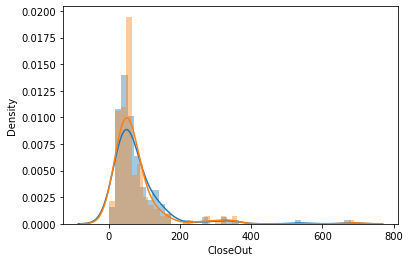

In [921]:
sns.distplot(same_CAR_data.CloseOut)
sns.distplot(same_SQL_data.CloseOut)

In [916]:
same_CAR_data.CloseOut.median(), same_CAR_data.CloseOut.mean(), same_CAR_data.CloseOut.max(), same_CAR_data.CloseOut.min()

(56.0, 79.0828729281768, 679, 1)

In [917]:
same_SQL_data.CloseOut.median(), same_SQL_data.CloseOut.mean(), same_SQL_data.CloseOut.max(), same_SQL_data.CloseOut.min()

(56.0, 73.89502762430939, 689, 2)

In [914]:
same_SQL_data.shape

(181, 7)

In [915]:
same_CAR_data.shape

(181, 7)